---
### Aunalytics Assessment In R // Problem Statement #1

By: Cody Culver // 
Date: 3/27/2022

---

#### Problem Statement
The prediction task is to determine whether
a person makes over 50K a year. Explain the
performance of the model using accuracy,
AUROC curve and confusion matrix. Feel
free to add any other metric you see fit.

#### Setting up analysis environment
setting up the R environment by loading the necessary packages and datasets.

In [1]:
# Importing the datasets
training_set = read.csv('au_train.csv')
test_set = read.csv('au_test.csv')

# Common data manipulation package
library(tidyverse)

# Machine Learning algorithms
install.packages('caret')
install.packages('xgboost')
install.packages('randomForest')
install.packages('e1071')
install.packages('pROC')
library(caret)
library(xgboost)
library(randomForest)
library(e1071)
library(pROC)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   2.1.1     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Installing package into ‘/srv/rlibs’
(as ‘lib’ is unspecified)

Installing package into ‘/srv/rlibs’
(as ‘lib’ is unspecified)

Installing package into ‘/srv/rlibs’
(as ‘lib’ is unspecified)

Installing package into ‘/srv/rlibs’
(as ‘lib’ is unspecified)

Installing package into ‘/srv/rlibs’
(as ‘lib’ is unspecified)

Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘package:purrr’:

    lift



Attaching package: ‘xgboost’


The following object is masked from ‘package:dplyr’:

    slice


randomForest 4.6-14

Type rfNews() to see new features/changes/bug

Going through typical data investigations via overviews, null checks, metadata confirmation, trimming, and sanity checks.

In [2]:
# 6 row overview of data set
head(training_set)

#checking for null values
sum(is.na(training_set))  #0 null values
sum(is.na(test_set))      #0 null values

# Checking for a list of unique values in categorical data to compare with metadata provided
# Will also report back "NULL" if there is an issue with a variable name
sort(unique(training_set$workclass))
sort(unique(training_set$education))
sort(unique(training_set$marital.status))
sort(unique(training_set$occupation))       # has an additional "?" variable type
sort(unique(training_set$relationship))
sort(unique(training_set$race))
sort(unique(training_set$sex))
sort(unique(training_set$native.country))   # has an additional "?" variable type
sort(unique(training_set$class))

# All data contains a white space as the first character in each variable. Trimming all white space to prevent errors:
# Need to use gsub function because white space is non ASCII type, and simple str_trim will not work.
training_set <- as.data.frame(apply(training_set, 2, function(training_set) gsub('\\s+','', training_set)))
test_set <- as.data.frame(apply(test_set, 2, function(test_set) gsub('\\s+','', test_set)))

# It was also discovered that the test_set includes an extra character on the dependent variable 'class', which must be removed
test_set <- as.data.frame(apply(test_set, 2, function(test_set) gsub('[.]','', test_set)))

# Checking that 'education.num' has the same amount of categories as 'education', and that the min to max values are methodical
n_distinct(training_set$education.num)  #16 distinct values
n_distinct(training_set$education)      #16 distinct values
summary(training_set$education.num)     #max numerical value of 16

# It looks like education has been factored appropriately for R based data science, so we can remove the education column
training_set <- subset(training_set, select = -education)
test_set <- subset(test_set, select = -education)


# The independent variables 'capital.gain' and 'capital.loss' seem to be mostly '0' values. Let's check the percentage of non zeros
capital.gain_occurrence = n_distinct(training_set$capital.gain) / nrow(training_set) * 100
capital.loss_occurrence = n_distinct(training_set$capital.loss) / nrow(training_set) * 100
# Both values are below 0.4%. I assume anything 0.5-1% to be unhelpful in learning, and would consider removing these variables, 
# but for the case of this assessment, I will perform models with and without

# Checking percentage of '?' occurrences. If less than 1%, may consider removing.
# first step is to count occurrences.
occ_count <- training_set %>% 
  count(occupation == '?') %>% 
  rename(exists = 'occupation == "?"')
occ_count_int = occ_count$n[occ_count$exists == 'TRUE']

n.c_count <- training_set %>% 
  count(native.country == '?') %>% 
  rename(exists = 'native.country == "?"')
n.c_count_int = n.c_count$n[n.c_count$exists == 'TRUE']

# Calculating percentage of occurrences.
occ_occurrence = occ_count_int / nrow(training_set) * 100
n.c_occurrence = n.c_count_int / nrow(training_set) * 100
# Both values are greater than 1%. Will treat as a separate categorical variable.

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,class
,<int>,<chr>,<int>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<int>,<chr>,<chr>
1,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
2,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
3,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
4,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
5,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
6,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K


[1] 0

[1] 0

[1] " ?"                " Federal-gov"      " Local-gov"       
[4] " Never-worked"     " Private"          " Self-emp-inc"    
[7] " Self-emp-not-inc" " State-gov"        " Without-pay"

[1] " 10th"         " 11th"         " 12th"         " 1st-4th"     
 [5] " 5th-6th"      " 7th-8th"      " 9th"          " Assoc-acdm"  
 [9] " Assoc-voc"    " Bachelors"    " Doctorate"    " HS-grad"     
[13] " Masters"      " Preschool"    " Prof-school"  " Some-college"

[1] " Divorced"              " Married-AF-spouse"     " Married-civ-spouse"   
[4] " Married-spouse-absent" " Never-married"         " Separated"            
[7] " Widowed"

[1] " ?"                 " Adm-clerical"      " Armed-Forces"     
 [4] " Craft-repair"      " Exec-managerial"   " Farming-fishing"  
 [7] " Handlers-cleaners" " Machine-op-inspct" " Other-service"    
[10] " Priv-house-serv"   " Prof-specialty"    " Protective-serv"  
[13] " Sales"             " Tech-support"      " Transport-moving"

[1] " Husband"        " Not-in-family"  " Other-relative" " Own-child"     
[5] " Unmarried"      " Wife"

[1] " Amer-Indian-Eskimo" " Asian-Pac-Islander" " Black"             
[4] " Other"              " White"

[1] " Female" " Male"

[1] " ?"                          " Cambodia"                  
 [3] " Canada"                     " China"                     
 [5] " Columbia"                   " Cuba"                      
 [7] " Dominican-Republic"         " Ecuador"                   
 [9] " El-Salvador"                " England"                   
[11] " France"                     " Germany"                   
[13] " Greece"                     " Guatemala"                 
[15] " Haiti"                      " Holand-Netherlands"        
[17] " Honduras"                   " Hong"                      
[19] " Hungary"                    " India"                     
[21] " Iran"                       " Ireland"                   
[23] " Italy"                      " Jamaica"                   
[25] " Japan"                      " Laos"                      
[27] " Mexico"                     " Nicaragua"                 
[29] " Outlying-US(Guam-USVI-etc)" " Peru"                      
[31] " Philippines"                " Poland"                    
[33] " Portugal"                   " Puerto-Rico"               
[35] " Scotland"                   " South"                     
[37] " Taiwan"                     " Thailand"                  
[39] " Trinadad&Tobago"            " United-States"             
[41] " Vietnam"                    " Yugoslavia"

[1] " <=50K" " >50K"

[1] 16

[1] 16

   Length     Class      Mode 
    32561 character character 

Next step is to encode categorical variables as factors. The last couple lines of code in this section scales all of the independent variables.

In [3]:
# Encoding the categorical variables as factors

# -------------------------
# Performing all categorical encoding to training data
# -------------------------
training_set$workclass = as.numeric(factor(training_set$workclass,
                                                levels = unique(training_set$workclass),
                                                labels = c(1:9)))

training_set$marital.status = as.numeric(factor(training_set$marital.status,
                                           levels = unique(training_set$marital.status),
                                           labels = c(1:7)))

training_set$occupation = as.numeric(factor(training_set$occupation,
                                                levels = unique(training_set$occupation),
                                                labels = c(1:15)))

training_set$relationship = as.numeric(factor(training_set$relationship,
                                                levels = unique(training_set$relationship),
                                                labels = c(1:6)))

training_set$race = as.numeric(factor(training_set$race,
                                              levels = unique(training_set$race),
                                              labels = c(1:5)))

training_set$sex = as.numeric(factor(training_set$sex,
                                  levels = c('Male', 'Female'),
                                  labels = c(1, 2)))

training_set$class = as.numeric(factor(training_set$class,
                                     levels = c('<=50K', '>50K'),
                                     labels = c(1, 2)))
# R indexing is 1-based. If I would try to force labels of 0 and 1, it still outputs 1 and 2. 
# So I need to subtract 1 from each value in the dependent variable to have proper binary notation for classification machine learning
training_set$class = as.numeric(training_set$class - 1)

#creating temp table of counts for distinct native.country variables pre factoring
pre_n.c_factor <- training_set %>% 
  count(native.country)
sort(pre_n.c_factor$n)

training_set$native.country = as.numeric(factor(training_set$native.country,
                                     levels = unique(training_set$native.country),
                                     labels = c(1:42)))

#creating temp table of counts for distinct native.country variables post factoring
post_n.c_factor <- training_set %>% 
  count(native.country)
sort(post_n.c_factor$n)

# Returns 'TRUE' if the sorted count values of pre and post factoring this large categorical data had the same counts
# This is a nice way to confirm no errors from the factoring of 42 categorical variables.
identical(sort(pre_n.c_factor$n), sort(post_n.c_factor$n))    #TRUE

# -------------------------
# Performing all categorical encoding to test data
# -------------------------

test_set$workclass = as.numeric(factor(test_set$workclass,
                                           levels = unique(test_set$workclass),
                                           labels = c(1:9)))

test_set$marital.status = as.numeric(factor(test_set$marital.status,
                                                levels = unique(test_set$marital.status),
                                                labels = c(1:7)))

test_set$occupation = as.numeric(factor(test_set$occupation,
                                            levels = unique(test_set$occupation),
                                            labels = c(1:15)))

test_set$relationship = as.numeric(factor(test_set$relationship,
                                              levels = unique(test_set$relationship),
                                              labels = c(1:6)))

test_set$race = as.numeric(factor(test_set$race,
                                      levels = unique(test_set$race),
                                      labels = c(1:5)))

test_set$sex = as.numeric(factor(test_set$sex,
                                     levels = c('Male', 'Female'),
                                     labels = c(1, 2)))

test_set$class = as.numeric(factor(test_set$class,
                                       levels = c('<=50K', '>50K'),
                                       labels = c(1, 2)))
test_set$class = as.numeric(test_set$class - 1)

test_set$native.country = as.numeric(factor(test_set$native.country,
                                                levels = unique(test_set$native.country),
                                                labels = c(1:41)))


# Confirming all variables are visibly numerical and checking variable types
head(training_set)
# converting and confirming all variables are numerical
training_set[] <- lapply(training_set, function(x) as.numeric(as.character(x)))
head(training_set)

test_set[] <- lapply(test_set, function(x) as.numeric(as.character(x)))
head(test_set)

#Values are numeric. Time to scale independent variables
# Feature Scaling
training_set[-14] = scale(training_set[-14])
test_set[-14] = scale(test_set[-14])

[1]     1    12    13    13    14    16    18    18    19    19    20    24
[13]    28    29    29    31    34    37    43    44    51    59    60    62
[25]    64    67    70    73    75    80    81    90    95   100   106   114
[37]   121   137   198   583   643 29170

[1]     1    12    13    13    14    16    18    18    19    19    20    24
[13]    28    29    29    31    34    37    43    44    51    59    60    62
[25]    64    67    70    73    75    80    81    90    95   100   106   114
[37]   121   137   198   583   643 29170

[1] TRUE

,age,workclass,fnlwgt,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,class
,<chr>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>
1,39,1,77516,13,1,1,1,1,1,2174,0,40,1,0
2,50,2,83311,13,2,2,2,1,1,0,0,13,1,0
3,38,3,215646,9,3,3,1,1,1,0,0,40,1,0
4,53,3,234721,7,2,3,2,2,1,0,0,40,1,0
5,28,3,338409,13,2,4,3,2,2,0,0,40,2,0
6,37,3,284582,14,2,2,3,1,2,0,0,40,1,0


,age,workclass,fnlwgt,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,class
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,39,1,77516,13,1,1,1,1,1,2174,0,40,1,0
2,50,2,83311,13,2,2,2,1,1,0,0,13,1,0
3,38,3,215646,9,3,3,1,1,1,0,0,40,1,0
4,53,3,234721,7,2,3,2,2,1,0,0,40,1,0
5,28,3,338409,13,2,4,3,2,2,0,0,40,2,0
6,37,3,284582,14,2,2,3,1,2,0,0,40,1,0


,age,workclass,fnlwgt,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,class
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,25,1,226802,7,1,1,1,1,1,0,0,40,1,0
2,38,1,89814,9,2,2,2,2,1,0,0,50,1,0
3,28,2,336951,12,2,3,2,2,1,0,0,40,1,1
4,44,1,160323,10,2,1,2,1,1,7688,0,40,1,1
5,18,3,103497,10,1,4,1,2,2,0,0,30,1,0
6,34,1,198693,6,1,5,3,2,1,0,0,30,1,0


#### Algorithm Comparisons and Predictions
Next, I am performing two variations of k-Fold Cross Validation using XGBoost. Due to the vast majority (>99.5%) of capital.gain and capital.loss values being '0', I want to determine if it is better to ignore these values or use them in the models.

In [4]:
# -------------------------
# Including capital.gain and capital.loss
# -------------------------

# Applying k-Fold Cross Validation to XGBoost
folds = createFolds(training_set$class, k = 10)
cv = lapply(folds, function(x) {
  training_fold = training_set[-x, ]
  test_fold = training_set[x, ]
  classifier = xgboost(data = as.matrix(training_fold[-14]), label = training_fold$class, nrounds = 10)
  y_pred = predict(classifier, newdata = as.matrix(test_fold[-14]))
  y_pred = (y_pred >= 0.5)
  cm = table(test_fold[, 14], y_pred)
  accuracy = (cm[1,1] + cm[2,2]) / (cm[1,1] + cm[2,2] + cm[1,2] + cm[2,1])
  return(accuracy)
})
average_accuracy = mean(as.numeric(cv))
cv
average_accuracy    # 0.8630877

# -------------------------
# Excluding capital.gain and capital.loss
# -------------------------

# Removing capital.gain and capital.loss variables
training_set2 <- subset(training_set, select = -c(capital.gain, capital.loss))
test_set2 <- subset(test_set, select = -c(capital.gain, capital.loss))

# Applying k-Fold Cross Validation to XGBoost
folds = createFolds(training_set2$class, k = 10)
cv = lapply(folds, function(x) {
  training_fold = training_set2[-x, ]
  test_fold = training_set2[x, ]
  classifier = xgboost(data = as.matrix(training_fold[-12]), label = training_fold$class, nrounds = 10)
  y_pred = predict(classifier, newdata = as.matrix(test_fold[-12]))
  y_pred = (y_pred >= 0.5)
  cm = table(test_fold[, 12], y_pred)
  accuracy = (cm[1,1] + cm[2,2]) / (cm[1,1] + cm[2,2] + cm[1,2] + cm[2,1])
  return(accuracy)
})
average_accuracy = mean(as.numeric(cv))
cv
average_accuracy    # 0.8386104

[1]	train-rmse:0.419012 
[2]	train-rmse:0.370688 
[3]	train-rmse:0.344090 
[4]	train-rmse:0.328461 
[5]	train-rmse:0.319063 
[6]	train-rmse:0.313281 
[7]	train-rmse:0.308808 
[8]	train-rmse:0.305528 
[9]	train-rmse:0.303408 
[10]	train-rmse:0.300926 
[1]	train-rmse:0.419033 
[2]	train-rmse:0.371415 
[3]	train-rmse:0.344481 
[4]	train-rmse:0.328957 
[5]	train-rmse:0.319411 
[6]	train-rmse:0.313369 
[7]	train-rmse:0.309524 
[8]	train-rmse:0.306385 
[9]	train-rmse:0.304435 
[10]	train-rmse:0.302339 
[1]	train-rmse:0.418706 
[2]	train-rmse:0.370990 
[3]	train-rmse:0.344002 
[4]	train-rmse:0.328280 
[5]	train-rmse:0.317856 
[6]	train-rmse:0.311989 
[7]	train-rmse:0.308026 
[8]	train-rmse:0.304917 
[9]	train-rmse:0.303076 
[10]	train-rmse:0.300878 
[1]	train-rmse:0.418987 
[2]	train-rmse:0.370587 
[3]	train-rmse:0.343632 
[4]	train-rmse:0.328081 
[5]	train-rmse:0.318498 
[6]	train-rmse:0.312723 
[7]	train-rmse:0.308906 
[8]	train-rmse:0.305976 
[9]	train-rmse:0.303710 
[10]	train-rmse:0.3016

$Fold01
[1] 0.8636364

$Fold02
[1] 0.8636364

$Fold03
[1] 0.8568796

$Fold04
[1] 0.8639435

$Fold05
[1] 0.8587224

$Fold06
[1] 0.8614865

$Fold07
[1] 0.8621007

$Fold08
[1] 0.8670147

$Fold09
[1] 0.8633292

$Fold10
[1] 0.8606079

[1] 0.8621357

[1]	train-rmse:0.425992 
[2]	train-rmse:0.383383 
[3]	train-rmse:0.359584 
[4]	train-rmse:0.346074 
[5]	train-rmse:0.338425 
[6]	train-rmse:0.333390 
[7]	train-rmse:0.330087 
[8]	train-rmse:0.327741 
[9]	train-rmse:0.325990 
[10]	train-rmse:0.324604 
[1]	train-rmse:0.426309 
[2]	train-rmse:0.383514 
[3]	train-rmse:0.359852 
[4]	train-rmse:0.346372 
[5]	train-rmse:0.338964 
[6]	train-rmse:0.334235 
[7]	train-rmse:0.330978 
[8]	train-rmse:0.328547 
[9]	train-rmse:0.326406 
[10]	train-rmse:0.325019 
[1]	train-rmse:0.426101 
[2]	train-rmse:0.383148 
[3]	train-rmse:0.359318 
[4]	train-rmse:0.345974 
[5]	train-rmse:0.338095 
[6]	train-rmse:0.333544 
[7]	train-rmse:0.330435 
[8]	train-rmse:0.328013 
[9]	train-rmse:0.326491 
[10]	train-rmse:0.324985 
[1]	train-rmse:0.426077 
[2]	train-rmse:0.383353 
[3]	train-rmse:0.359658 
[4]	train-rmse:0.346199 
[5]	train-rmse:0.338438 
[6]	train-rmse:0.333372 
[7]	train-rmse:0.330325 
[8]	train-rmse:0.327941 
[9]	train-rmse:0.326099 
[10]	train-rmse:0.3247

$Fold01
[1] 0.8442875

$Fold02
[1] 0.8458231

$Fold03
[1] 0.8310811

$Fold04
[1] 0.8360454

$Fold05
[1] 0.8387592

$Fold06
[1] 0.8421376

$Fold07
[1] 0.8369165

$Fold08
[1] 0.8387592

$Fold09
[1] 0.8387592

$Fold10
[1] 0.8359951

[1] 0.8388564

Even though capital.gain and capital.loss contain majority value '0', it seems that where non zero values are present, some learning can still be provided, as including capital variables improved the average accuracy of 10 cross validations.

Returning to datasets that include capital.gain and capital.loss, I will be comparing k-fold cross validations of XGBoost and Kernel SVM, along with a standard Random Forest method. It is my understanding that Random Forest does not require cross validation, as it is built into the method.

In [5]:
# -------------------------
# Returning to including capital.gain and capital.loss
# -------------------------

# Applying k-Fold Cross Validation to XGBoost
#-------------------------------
folds = createFolds(training_set$class, k = 10)
xgb_cv = lapply(folds, function(x) {
  training_fold = training_set[-x, ]
  test_fold = training_set[x, ]
  classifier = xgboost(data = as.matrix(training_fold[-14]), label = training_fold$class, nrounds = 10)
  y_pred = predict(classifier, newdata = as.matrix(test_fold[-14]))
  y_pred = (y_pred >= 0.5)
  cm = table(test_fold[, 14], y_pred)
  accuracy = (cm[1,1] + cm[2,2]) / (cm[1,1] + cm[2,2] + cm[1,2] + cm[2,1])
  return(accuracy)
})
xgb_average_accuracy = mean(as.numeric(xgb_cv))
#sanity check of cv
xgb_cv

# Applying Random Forest Prediction (No need for k-Fold, it's built in)
#------------------------------
rf_classifier = randomForest(x = training_set[-14],
                             y = training_set$class,
                             ntree = 10)
# Predicting the Test set results
rf_y_pred = predict(rf_classifier, newdata = as.matrix(test_set[-14]))
rf_y_pred = (rf_y_pred >= 0.5)

# Making the Confusion Matrix
rf_cm = table(test_set[, 14], rf_y_pred)
#sanity check of cm
rf_cm
rf_accuracy = (rf_cm[1,1] + rf_cm[2,2]) / (rf_cm[1,1] + rf_cm[2,2] + rf_cm[1,2] + rf_cm[2,1])

# Applying k-Fold Cross Validation to Kernel SVM
# This section will be commented out because it takes 10+ minutes to run,
# however the accuracy value was prerecorded and noted below
#-------------------------------
    # folds = createFolds(training_set$class, k = 10)
    # svm_cv = lapply(folds, function(x) {
    #   training_fold = training_set[-x, ]
    #   test_fold = training_set[x, ]
    #   classifier = svm(formula = class ~ .,
    #                    data = training_fold,
    #                    type = 'C-classification',
    #                    kernel = 'radial')
    #   y_pred = predict(classifier, newdata = test_fold[-14])
    #   cm = table(test_fold[, 14], y_pred)
    #   accuracy = (cm[1,1] + cm[2,2]) / (cm[1,1] + cm[2,2] + cm[1,2] + cm[2,1])
    #   return(accuracy)
    # })
    # svm_average_accuracy = mean(as.numeric(svm_cv))
    # #sanity check of cv
    # svm_cv

#comparing accuracies of the different algorithms.
xgb_average_accuracy    # 0.8627501
rf_accuracy             # 0.8353737
# svm_average_accuracy    # 0.8482847
# Although the accuracy value is near that of 'xgb_average_accuracy', the processing time is significantly longer. 
# Moving forward with XGBoost

[1]	train-rmse:0.419164 
[2]	train-rmse:0.371802 
[3]	train-rmse:0.344978 
[4]	train-rmse:0.330102 
[5]	train-rmse:0.320247 
[6]	train-rmse:0.314085 
[7]	train-rmse:0.310325 
[8]	train-rmse:0.307360 
[9]	train-rmse:0.304581 
[10]	train-rmse:0.302138 
[1]	train-rmse:0.418866 
[2]	train-rmse:0.370451 
[3]	train-rmse:0.343602 
[4]	train-rmse:0.327955 
[5]	train-rmse:0.318303 
[6]	train-rmse:0.311670 
[7]	train-rmse:0.307688 
[8]	train-rmse:0.305169 
[9]	train-rmse:0.302490 
[10]	train-rmse:0.300577 
[1]	train-rmse:0.419436 
[2]	train-rmse:0.371292 
[3]	train-rmse:0.344531 
[4]	train-rmse:0.328662 
[5]	train-rmse:0.319402 
[6]	train-rmse:0.313643 
[7]	train-rmse:0.309272 
[8]	train-rmse:0.306165 
[9]	train-rmse:0.304051 
[10]	train-rmse:0.302007 
[1]	train-rmse:0.419311 
[2]	train-rmse:0.371036 
[3]	train-rmse:0.344101 
[4]	train-rmse:0.329092 
[5]	train-rmse:0.319360 
[6]	train-rmse:0.313338 
[7]	train-rmse:0.309282 
[8]	train-rmse:0.305906 
[9]	train-rmse:0.303352 
[10]	train-rmse:0.3007

$Fold01
[1] 0.8722359

$Fold02
[1] 0.860258

$Fold03
[1] 0.8753071

$Fold04
[1] 0.8728501

$Fold05
[1] 0.8587224

$Fold06
[1] 0.860258

$Fold07
[1] 0.8578446

$Fold08
[1] 0.8630221

$Fold09
[1] 0.8694717

$Fold10
[1] 0.8442875

Warning message in randomForest.default(x = training_set[-14], y = training_set$class, :
“The response has five or fewer unique values.  Are you sure you want to do regression?”


   rf_y_pred
    FALSE  TRUE
  0 11237  1198
  1  1793  2053

[1] 0.8634257

[1] 0.8162889

The accuracy values are:
* k-FCV XGBoost: 86.275%
* Random Forest: 83.537%
* k-FCV Kernel SVM: 84.285%

The XG Boost algorithm has the best accuracy, and therefore will be used acquire a confusion matrix and AUROC curve. AUROC curves can be created quickly, so I will also compare with the Random Forest algorithm. It is worth noting that Kernel SVM took a over 10 minutes to run, which is why I will be avoiding collecting a single run confusion matrix.

In [6]:
# Single XGBoost to get a confusion matrix
# -------------------------
library(xgboost)
xgb_classifier = xgboost(data = as.matrix(training_set[-14]),
                         label = training_set$class,
                         nrounds = 10)
# Predicting the Test set results
xgb_y_pred = predict(xgb_classifier, newdata = as.matrix(test_set[-14]))
xgb_y_pred = (xgb_y_pred >= 0.5)

# Making the Confusion Matrix
xgb_cm = table(test_set[, 14], xgb_y_pred)
xgb_accuracy = (xgb_cm[1,1] + xgb_cm[2,2]) / (xgb_cm[1,1] + xgb_cm[2,2] + xgb_cm[1,2] + xgb_cm[2,1])
xgb_cm
xgb_accuracy    # 0.8524661

[1]	train-rmse:0.419097 
[2]	train-rmse:0.370599 
[3]	train-rmse:0.343747 
[4]	train-rmse:0.328332 
[5]	train-rmse:0.318482 
[6]	train-rmse:0.312683 
[7]	train-rmse:0.308881 
[8]	train-rmse:0.306245 
[9]	train-rmse:0.303649 
[10]	train-rmse:0.301772 


   xgb_y_pred
    FALSE  TRUE
  0 11912   523
  1  1879  1967

[1] 0.8524661

Looking at the confusion matrix, imediately we can see that the True Positive and True Negative values are greater than the False Positive and False Negative values, which is good. However, the values for False Positive and False Negative are still significant. A majority of the possible independent variable combinations will lead to a class variable value of '<=50K'.

The accuracy value of this single fold algorithm is 85.247%, which is not bad, but this algorithm could possibly be improved by having more accurate data recorded for indepedent variables 'capital.gain' and 'capital.loss'.

Lastly we will calculate the Area Under the Receiver Operating Characteristic (AUROC). 

Setting levels: control = 0, case = 1

Setting direction: controls < cases




Call:
roc.default(response = test_set[, 14], predictor = as.integer(xgb_y_pred),     percent = TRUE, plot = TRUE, print.auc = TRUE, col = "green",     lwd = 4, main = "XG Boost vs RF ROC Curve")

Data: as.integer(xgb_y_pred) in 12435 controls (test_set[, 14] 0) < 3846 cases (test_set[, 14] 1).
Area under the curve: 73.47%

Setting levels: control = 0, case = 1

Setting direction: controls < cases



Area under the curve: 0.7347

Setting levels: control = 0, case = 1

Setting direction: controls < cases




Call:
roc.default(response = test_set[, 14], predictor = as.integer(rf_y_pred),     percent = TRUE, plot = TRUE, print.auc = TRUE, col = "blue",     lwd = 4, print.auc.y = 45, add = TRUE)

Data: as.integer(rf_y_pred) in 12435 controls (test_set[, 14] 0) < 3846 cases (test_set[, 14] 1).
Area under the curve: 71.87%

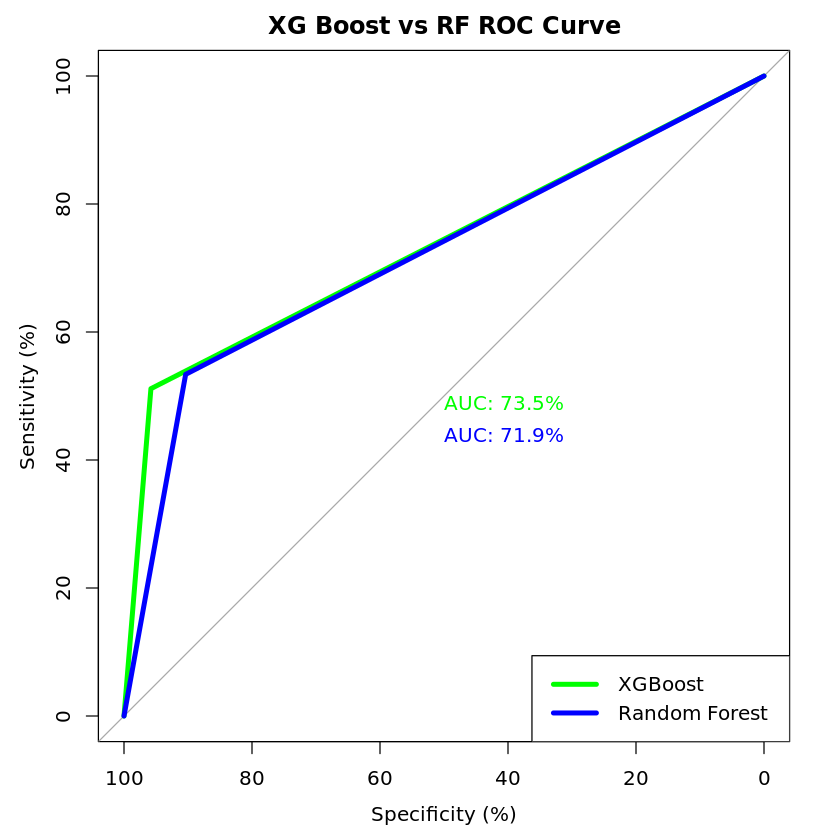

In [7]:
# Plotting and calculating AUROC for XGBoost
par(pty = 's')
roc(test_set[, 14], as.integer(xgb_y_pred), percent = TRUE, plot = TRUE, print.auc = TRUE, col = 'green', lwd = 4, main = 'XG Boost vs RF ROC Curve')
# Confirming AUC value
auc(test_set$class, as.integer(xgb_y_pred))

# Plotting and calculating AUROC of RF for comparison
roc(test_set[, 14], as.integer(rf_y_pred), percent = TRUE, plot = TRUE, print.auc = TRUE, col = 'blue', lwd = 4, print.auc.y = 45, add = TRUE)
legend("bottomright",legend=c("XGBoost","Random Forest"),col=c("green","blue"),lwd=4)

The XGBoost AUROC curve is a slight improvement over the random forest AUROC curve. Both algorithms have good discriminatory ability, having AUC values greater than 0.7. The XGBoost algorithm has an AUC value of 0.735, meaning that 73.5% of the time, the model will correctly assign a salary range to a randomly selecting individual when knowing all the values of that individual's independent variables. However, having a value above 0.8 would mean the algorithm is very solid, and should be the target for an appropriate algorithm. Again, I feel like having more notable values than '0' for 'capital.gain' and 'capital.loss' would improve the algorithm, maybe getting the AUC value above 0.8.